## Get data from Yahoo Finance 

Obtenemos los dtaos de [yahoo](https://es.finance.yahoo.com/)

Buscamos un ticker, por ejemplo Cisco (CSCO)

<center>
<img src="imgs/yf_cisco.png"  alt="drawing" width="50%"/>
</center>

Obtenemos los datos de opciones de Cisco [aquí](https://finance.yahoo.com/quote/CSCO/options?p=CSCO)

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import datetime
import mibian

import warnings
warnings.filterwarnings("ignore")

In [4]:
msft = yf.Ticker("MSFT")
csco = yf.Ticker("CSCO")

# get historical market data
msft_hist = msft.history(period="max")
csco_hist = csco.history(period="max")

csco_hist= csco_hist[csco_hist.index > '2020-01-01']

Elijo una fecha de vencimiento entre las disponibles

In [5]:
# show options expirations
exp_dates = csco.options
print(' Las fechas de vencimiento disponibles son : ', exp_dates)

#elijo, por ejemplo, la fecha de la que está en el noveno lugar
vcto_str = exp_dates[9] 
print('\n La fecha de vencimiento elegida es : ', vcto_str)

 Las fechas de vencimiento disponibles son :  ('2022-10-14', '2022-10-21', '2022-10-28', '2022-11-04', '2022-11-11', '2022-11-18', '2022-11-25', '2022-12-16', '2023-01-20', '2023-03-17', '2023-04-21', '2023-06-16', '2024-01-19', '2024-06-21', '2025-01-17')

 La fecha de vencimiento elegida es :  2023-03-17


Elijo todas las opciones con  fecha de vencimiento igual a la elegida

In [7]:
# get option chain for specific expiration
csco_opt = csco.option_chain(vcto_str)  

# data available via: opt.calls, opt.puts
csco_opt_calls = csco_opt.calls.loc[:, ['lastTradeDate', 'strike', 'lastPrice']]

#convert lastTradeDate to date format
csco_opt_calls.lastTradeDate = csco_opt_calls.lastTradeDate.apply(lambda x: x.date())



csco_opt_calls

,lastTradeDate,strike,lastPrice
0,2022-08-29,22.5,23.25
1,2022-07-18,27.5,16.15
2,2022-10-13,30.0,10.05
3,2022-10-12,32.5,7.95
4,2022-09-26,35.0,6.20
5,2022-10-13,37.5,4.40
6,2022-10-13,40.0,3.15
7,2022-10-13,42.5,2.66
8,2022-10-13,45.0,1.34
9,2022-10-13,47.5,1.05


Selecciono aquellas que se negociaron en una fecha determinada

In [8]:
# elijo, por ejemplo, la que está en el séptimo lugar
posicion=7
trade_date = csco_opt_calls.iloc[posicion]['lastTradeDate']
csco_opt_calls = csco_opt_calls[csco_opt_calls['lastTradeDate'] == trade_date]
csco_opt_calls

,lastTradeDate,strike,lastPrice
2,2022-10-13,30.0,10.05
5,2022-10-13,37.5,4.40
6,2022-10-13,40.0,3.15
7,2022-10-13,42.5,2.66
8,2022-10-13,45.0,1.34
9,2022-10-13,47.5,1.05
11,2022-10-13,52.5,0.26
12,2022-10-13,55.0,0.17
13,2022-10-13,57.5,0.13


Elegimos la primera, obtenemos todos los datos
- S:            Valor del activo subyacente
- K:            Valor de strike de la opción
- T:            Tiempo hasta vencimiento (en % de años)
- market_price: Valor de la opción en el mercado

 y, usando una librería de python (mibiam) calculamos la volatilidad implícita

Calculamos los parámetros comunes a todas las opciones

In [9]:
vcto = datetime.datetime.strptime(vcto_str, '%Y-%m-%d')
T = ((vcto.date()-trade_date).days)/365
S0 = csco_hist.loc[trade_date.strftime('%Y-%m-%d')]['Close']

csco_opt_calls["S0"] = S0
csco_opt_calls["T"] = T

Calculamos la volatilidad implícita para cada opción




In [10]:
days = T * 365
vols = []
for i in range(csco_opt_calls.shape[0]):
    K = csco_opt_calls['strike'].iloc[i]
    market_price = csco_opt_calls['lastPrice'].iloc[i]
    c_vol = mibian.BS([S0, K, 0, days], callPrice= market_price)
    vols.append(c_vol.impliedVolatility)
csco_opt_calls["vol"] = vols

In [19]:
csco_opt_calls

,lastTradeDate,strike,lastPrice,S0,T,vol
2,2022-10-13,30.0,10.05,40.52,0.424658,0.000010
5,2022-10-13,37.5,4.40,40.52,0.424658,25.390625
6,2022-10-13,40.0,3.15,40.52,0.424658,27.587891
7,2022-10-13,42.5,2.66,40.52,0.424658,33.081055
8,2022-10-13,45.0,1.34,40.52,0.424658,27.709961
9,2022-10-13,47.5,1.05,40.52,0.424658,30.517578
11,2022-10-13,52.5,0.26,40.52,0.424658,27.099609
12,2022-10-13,55.0,0.17,40.52,0.424658,28.076172
13,2022-10-13,57.5,0.13,40.52,0.424658,29.785156


<AxesSubplot: xlabel='strike'>

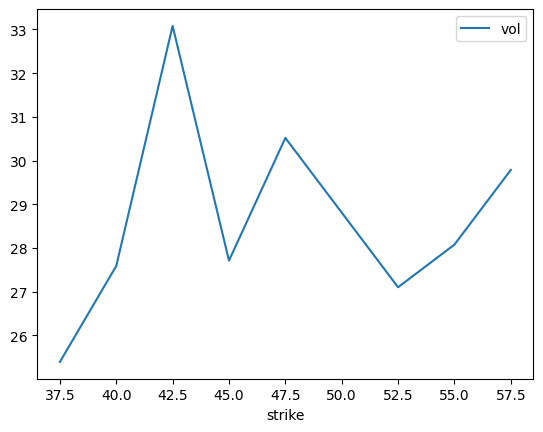

In [21]:
csco_opt_calls.iloc[1:].plot(kind='line', x= "strike", y="vol")

In [23]:
csco_opt_calls.iloc[1:]['vol'].mean()

28.656005859375

In [12]:
#save to file
csco_opt_calls.to_excel("../data/csco_opt.xlsx", index=False)

## Análisis de volatilidad histórica

In [12]:
csco_hist['Close']

Date
2020-01-02 00:00:00-05:00    44.417831
2020-01-03 00:00:00-05:00    43.693127
2020-01-06 00:00:00-05:00    43.849075
2020-01-07 00:00:00-05:00    43.564705
2020-01-08 00:00:00-05:00    43.592224
                               ...    
2022-10-07 00:00:00-04:00    40.270000
2022-10-10 00:00:00-04:00    39.889999
2022-10-11 00:00:00-04:00    39.580002
2022-10-12 00:00:00-04:00    39.270000
2022-10-13 00:00:00-04:00    40.520000
Name: Close, Length: 702, dtype: float64

In [ ]:
days = 252

In [13]:
(csco_hist['Close'].pct_change().std())*np.sqrt(days)

0.32014697515896945

In [14]:
(csco_hist['Close'].rolling(int(days)).std()).mean()*np.sqrt(days)

56.0942794396712

<AxesSubplot: xlabel='Date'>

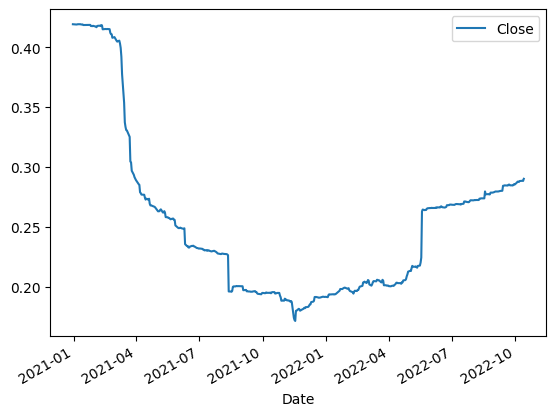

In [18]:
(csco_hist[['Close']].pct_change().rolling(days).std()*np.sqrt(days)).plot()